In [1]:
from pymongo import MongoClient
from concurrent.futures import ThreadPoolExecutor
from threading import Lock
import time
import math
import matplotlib.pyplot as plt
import os

Конфігурація та підключення до бази даних

In [2]:
lock = Lock()

MONGODB_URI = os.environ.get("MONGODB_URI", "mongodb://localhost:27017")
client = MongoClient(MONGODB_URI, username="root", password="root")
db = client.cafes
cafes = db.cafes

Тестові операції для роботи з СУБД

In [3]:
def transfer_funds(from_account, to_account, amount):
    cafe = cafes.find_one({'name': from_account})
    
    lock.acquire()
    cafes.update_one({'name': from_account}, {'$inc': {'rating': -amount}})
    cafes.update_one({'name': to_account}, {'$inc': {'rating': amount}})
    lock.release()

def credit_funds(to_account_name, amount):
    lock.acquire()
    cafes.update_one({'name': to_account_name}, {'$inc': {'rating': amount}})
    lock.release()

Бенчмарк

In [4]:
def run_transactions(num_threads, num_transactions):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        start_time = time.time()
        
        for _ in range(num_transactions):
            futures.append(executor.submit(lambda: transfer_funds("Starbucks", "Cafe Coffee Day", 0.01)))
            futures.append(executor.submit(lambda: transfer_funds("Cafe Coffee Day", "Dunkin Donuts", 0.01)))
            futures.append(executor.submit(lambda: transfer_funds("Dunkin Donuts", "Tim Hortons", 0.01)))

        for _ in range(math.floor(num_transactions / 2)):
            futures.append(executor.submit(lambda: credit_funds("Starbucks", 0.01)))
            futures.append(executor.submit(lambda: credit_funds("Cafe Coffee Day", 0.01)))
        
        for future in futures:
            future.result()

        executor.shutdown()
        
        end_time = time.time()
        return end_time - start_time

Main

In [5]:
num_threads = 50
num_transactions = 100
iterations = 50
times = []
for i in range(iterations):
    time_taken = run_transactions(num_threads, num_transactions)
    times.append(time_taken)
    print(f'Completed {num_transactions + num_transactions / 2} transactions in {i+1} iteration in {time_taken:.4f} seconds')

Completed 150.0 transactions in 1 iteration in 1.0668 seconds
Completed 150.0 transactions in 2 iteration in 0.9876 seconds
Completed 150.0 transactions in 3 iteration in 0.9953 seconds
Completed 150.0 transactions in 4 iteration in 0.9729 seconds
Completed 150.0 transactions in 5 iteration in 0.9075 seconds
Completed 150.0 transactions in 6 iteration in 0.9935 seconds
Completed 150.0 transactions in 7 iteration in 1.0130 seconds
Completed 150.0 transactions in 8 iteration in 0.9493 seconds
Completed 150.0 transactions in 9 iteration in 1.0450 seconds
Completed 150.0 transactions in 10 iteration in 0.9969 seconds
Completed 150.0 transactions in 11 iteration in 0.9225 seconds
Completed 150.0 transactions in 12 iteration in 0.8302 seconds
Completed 150.0 transactions in 13 iteration in 0.8769 seconds
Completed 150.0 transactions in 14 iteration in 0.8575 seconds
Completed 150.0 transactions in 15 iteration in 0.8528 seconds
Completed 150.0 transactions in 16 iteration in 0.8356 seconds
C

Побудова графіків

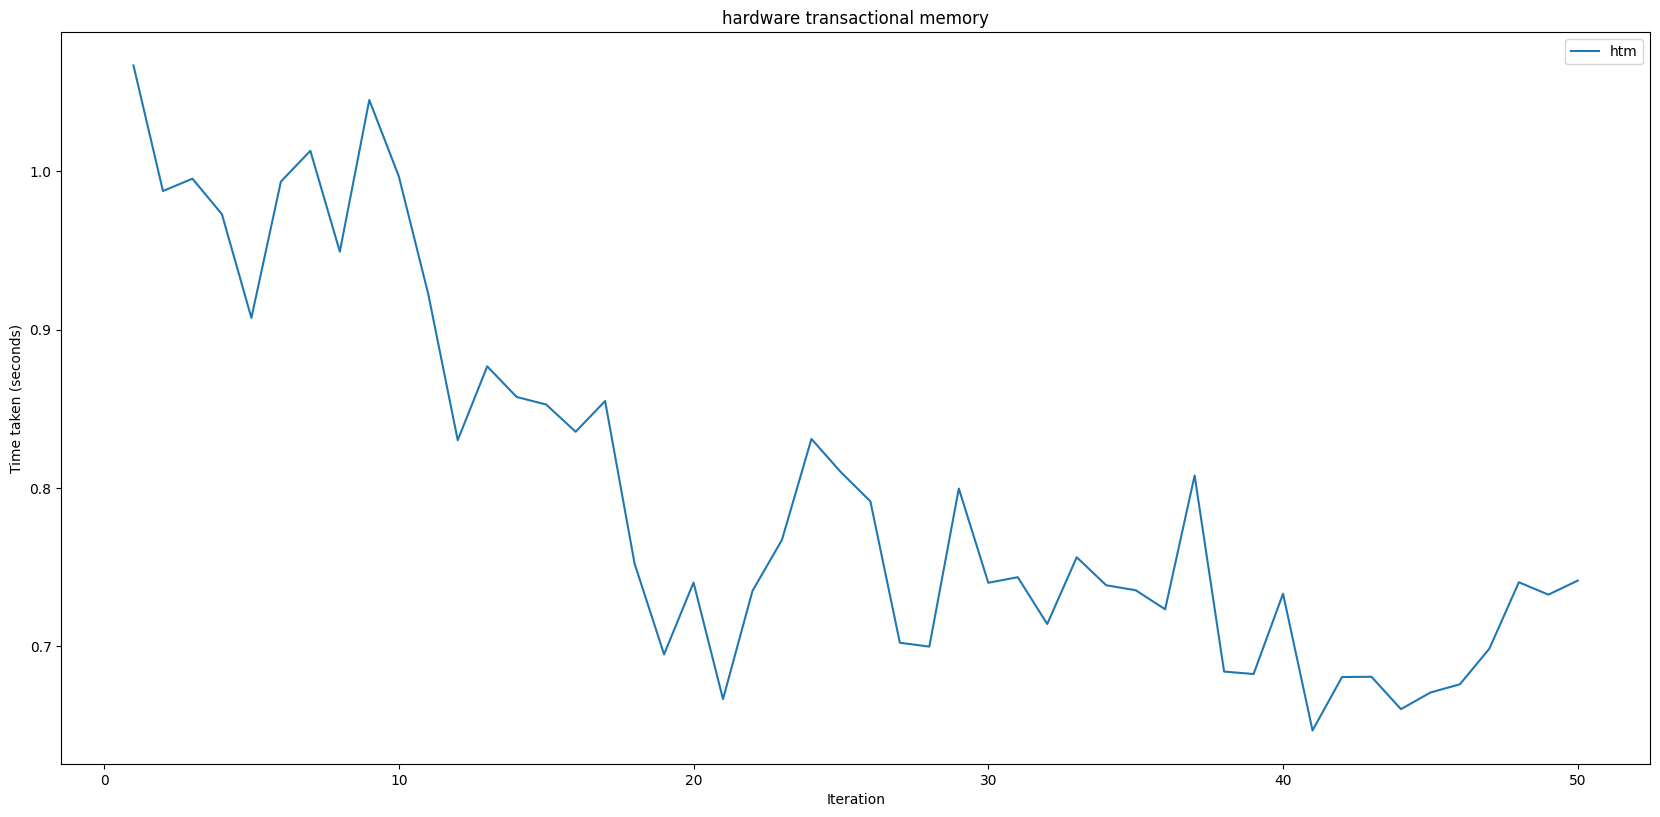

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 9.5)
ax.plot(range(1, iterations+1), times, label='htm')
ax.set_xlabel('Iteration')
ax.set_ylabel('Time taken (seconds)')

ax.set_title('Hardware Transactional memory')
ax.legend()
plt.show()